In [948]:
import pandas as pd
import numpy as np

from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, f1_score

from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import titanic_tools

In [949]:
columns = ['Survived', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Parch', 'Fare', 'Name', 'Age', 'Embarked', 'Ticket']
traindf = pd.read_csv('train.csv', usecols=columns).set_index('PassengerId',)
testdf = pd.read_csv('test.csv', usecols=columns[1:]).set_index('PassengerId')
df = pd.concat([traindf, testdf], axis=0, sort=False)

df.Pclass = df.Pclass.astype('category')

df.Sex.replace({'male':1, 'female':0}, inplace=True)

df['FamilySize'] = df.SibSp + df.Parch + 1

df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
df['Title'] = df.Title.replace('Ms','Miss')
df['Title'] = df.Title.replace('Mlle','Miss')
df['Title'] = df.Title.replace('Mme','Mrs')
df['Title'] = df.Title.apply(titanic_tools.replace_not_important_with_others)

df['Mother'] = np.where((df.Title=='Mrs') & (df.Parch >0), 1, 0)
df['Free'] = np.where(df['Fare']==0, 1,0)
df['Ticket'] = df.Ticket.apply(titanic_tools.extract_ticket_type)

df.Age.fillna(df.Title, inplace=True)
df.Age = df.Age.apply(titanic_tools.get_age_by_title)
bins = [0,12,24,45,60,df.Age.max()]
labels = ['Child', 'Young Adult', 'Adult','Older Adult','Senior']
df.Age = pd.cut(df["Age"], bins, labels = labels)

df.Fare.fillna(13,inplace=True)
df.Embarked.fillna('S',inplace=True)

df.drop(['SibSp','Parch','Name'],axis=1, inplace=True)

df = pd.get_dummies(df)

In [950]:
df.head(10)

,Survived,Sex,Fare,FamilySize,Mother,Free,Pclass_1,Pclass_2,Pclass_3,Age_Child,...,Ticket_WC,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1,7.2500,2,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,1.0,0,71.2833,2,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1.0,0,7.9250,1,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,1.0,0,53.1000,2,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0.0,1,8.0500,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
6,0.0,1,8.4583,1,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
7,0.0,1,51.8625,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,1,0,0
8,0.0,1,21.0750,5,0,0,0,0,1,1,...,0,0,0,1,0,1,0,0,0,0
9,1.0,0,11.1333,3,1,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0


In [951]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Survived             891 non-null    float64
 1   Sex                  1309 non-null   int64  
 2   Fare                 1309 non-null   float64
 3   FamilySize           1309 non-null   int64  
 4   Mother               1309 non-null   int64  
 5   Free                 1309 non-null   int64  
 6   Pclass_1             1309 non-null   uint8  
 7   Pclass_2             1309 non-null   uint8  
 8   Pclass_3             1309 non-null   uint8  
 9   Age_Child            1309 non-null   uint8  
 10  Age_Young Adult      1309 non-null   uint8  
 11  Age_Adult            1309 non-null   uint8  
 12  Age_Older Adult      1309 non-null   uint8  
 13  Age_Senior           1309 non-null   uint8  
 14  Ticket_A             1309 non-null   uint8  
 15  Ticket_CA            1309 non-null   u

In [952]:
df[['Fare', 'FamilySize']] = StandardScaler().fit_transform(df[['Fare', 'FamilySize']])
df.head(5)

,Survived,Sex,Fare,FamilySize,Mother,Free,Pclass_1,Pclass_2,Pclass_3,Age_Child,...,Ticket_WC,Embarked_C,Embarked_Q,Embarked_S,Title_Dr,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Others
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0.0,1,-0.503265,0.073352,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0
2,1.0,0,0.734759,0.073352,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
3,1.0,0,-0.490215,-0.558346,0,0,0,0,1,0,...,0,0,0,1,0,0,1,0,0,0
4,1.0,0,0.383202,0.073352,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,0.0,1,-0.487798,-0.558346,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,0,0


## features selection:

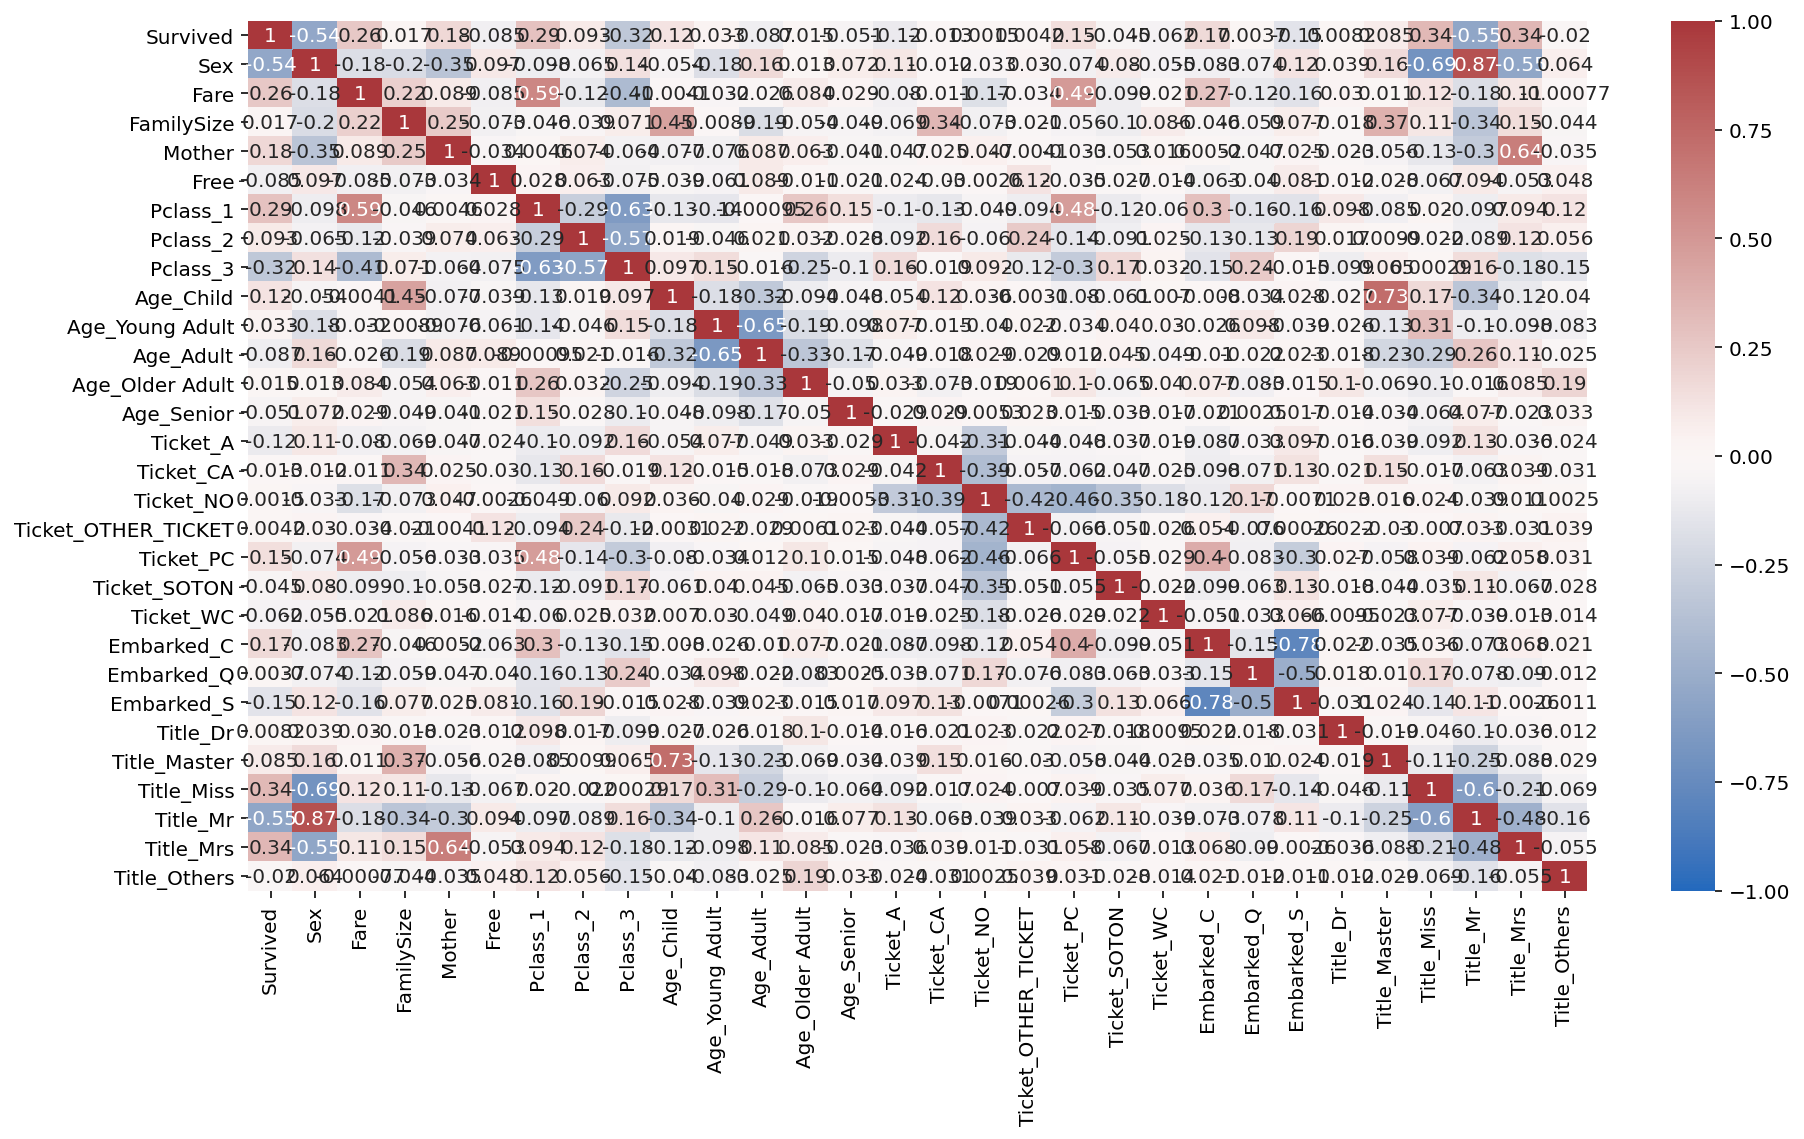

In [953]:
train_corr = df.loc[traindf.index].corr()
plt.figure(figsize=(15,8))
sns.heatmap(train_corr,center=0,vmin=-1, vmax=1,cmap='vlag', annot=True);

In [954]:
CORR_THRESHOLD = 0.01
corr_with_target = abs(train_corr['Survived'])
selected_columnes_by_corr = corr_with_target[corr_with_target > CORR_THRESHOLD]
selected_columnes_by_corr

Survived           1.000000
Sex                0.543351
Fare               0.257307
FamilySize         0.016639
Mother             0.175967
Free               0.085343
Pclass_1           0.285904
Pclass_2           0.093349
Pclass_3           0.322308
Age_Child          0.117636
Age_Young Adult    0.032829
Age_Adult          0.086860
Age_Older Adult    0.015326
Age_Senior         0.051224
Ticket_A           0.115712
Ticket_CA          0.013413
Ticket_PC          0.147062
Ticket_SOTON       0.044751
Ticket_WC          0.062182
Embarked_C         0.168240
Embarked_S         0.149683
Title_Master       0.085221
Title_Miss         0.335636
Title_Mr           0.549199
Title_Mrs          0.341994
Title_Others       0.019836
Name: Survived, dtype: float64

In [955]:
X = df[list(selected_columnes_by_corr.index)].loc[traindf.index].drop(['Survived'],axis=1)
y = df.Survived.loc[traindf.index]

In [956]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=42)
kfold = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

In [957]:
# rf_m = RandomForestClassifier(n_estimators=500,random_state=42)
# est = RFECV(estimator=rf_m, step=1, cv=kfold, scoring='f1_weighted')
# est.fit(X_train,y_train);
# print(classification_report(y_test, est.predict(X_test)))

In [958]:
# print("Optimal number of features : %d" % est.n_features_)
# plt.figure()
# plt.xlabel("Number of features selected")
# plt.ylabel("Cross validation score (nb of correct classifications)")
# plt.plot(range(1, len(est.grid_scores_) + 1), est.grid_scores_)
# plt.show()
# print(X.columns[est.support_])

In [959]:
# rf_m.fit(X_train,y_train)
# pd.DataFrame(rf_m.feature_importances_, index=X.columns, columns=['feature importance'])\
# .sort_values('feature importance').plot(kind='barh');

In [960]:
# X = df[X.columns[est.support_]].loc[traindf.index]
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.20, random_state=42)

# model selection:

In [961]:
for model in [
    LogisticRegression,
    SVC,
    RandomForestClassifier,
    xgboost.XGBClassifier]:
    cls = model()
    s = cross_val_score(cls, X, y, scoring="roc_auc", cv=kfold)

    print(f"{model.__name__ :22} AUC: {s.mean(): .3f} STD: {s.std(): .2f}")

LogisticRegression     AUC:  0.871 STD:  0.03
SVC                    AUC:  0.870 STD:  0.04
RandomForestClassifier AUC:  0.871 STD:  0.04
XGBClassifier          AUC:  0.880 STD:  0.05


## let's consider RandomForest & XGB models
### 1. RandomForestClassifier

In [962]:
parameters = {'n_estimators':range(1000,3000,500),
              'max_depth': range(4,8,2)}
rf_clf = GridSearchCV(RandomForestClassifier(random_state=42), parameters, cv=kfold, n_jobs=-1,scoring='f1_weighted')

rf_clf.fit(X_train, y_train)
rf_predicted = rf_clf.predict(X_test)

print('RandomForest:')
print(classification_report(y_test, rf_predicted))
print('\n' + str(rf_clf.best_estimator_))

RandomForest:
              precision    recall  f1-score   support

         0.0       0.84      0.90      0.87       105
         1.0       0.84      0.76      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179


RandomForestClassifier(max_depth=6, n_estimators=1000, random_state=42)


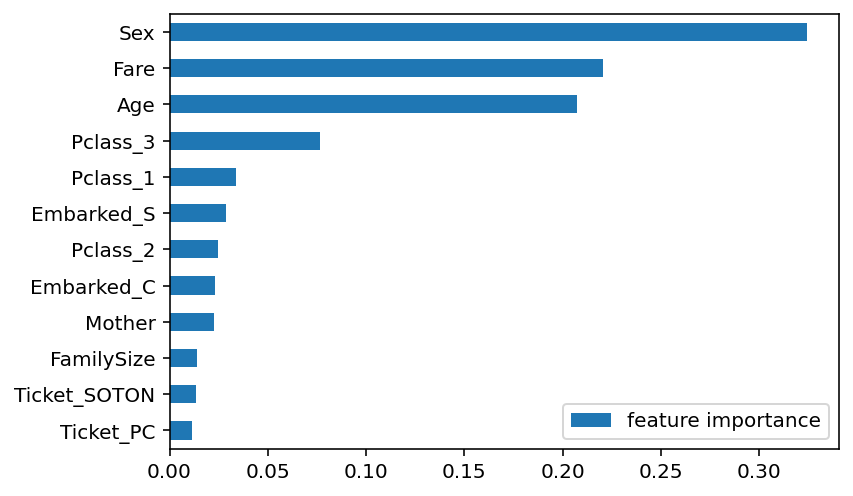

In [698]:
pd.DataFrame(rf_clf.best_estimator_.feature_importances_, index=X.columns, columns=['feature importance'])\
.sort_values('feature importance').plot(kind='barh');

In [964]:
parameters = {'learning_rate': np.arange(0.001,0.01, 0.002),
              'max_depth': [6],
              'min_child_weight': [4,6],
              'subsample': [0.7],
              'colsample_bytree': [0.8],
              'n_estimators': [2000]}
xgb_clf = GridSearchCV(xgboost.XGBClassifier(random_state=42), parameters, n_jobs=-1, 
                       cv=kfold, scoring='f1_weighted', refit=True)

xgb_clf.fit(X_train, y_train)
xgb_predicted = xgb_clf.predict(X_test)

print(classification_report(y_test, xgb_predicted))
print('\n' + str(xgb_clf.best_estimator_))

              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88       105
         1.0       0.83      0.84      0.83        74

    accuracy                           0.86       179
   macro avg       0.86      0.86      0.86       179
weighted avg       0.86      0.86      0.86       179


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.009000000000000001, max_delta_step=0, max_depth=6,
              min_child_weight=4, missing=nan, monotone_constraints='()',
              n_estimators=2000, n_jobs=0, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.7,
              tree_method='exact', validate_parameters=1, verbosity=None)


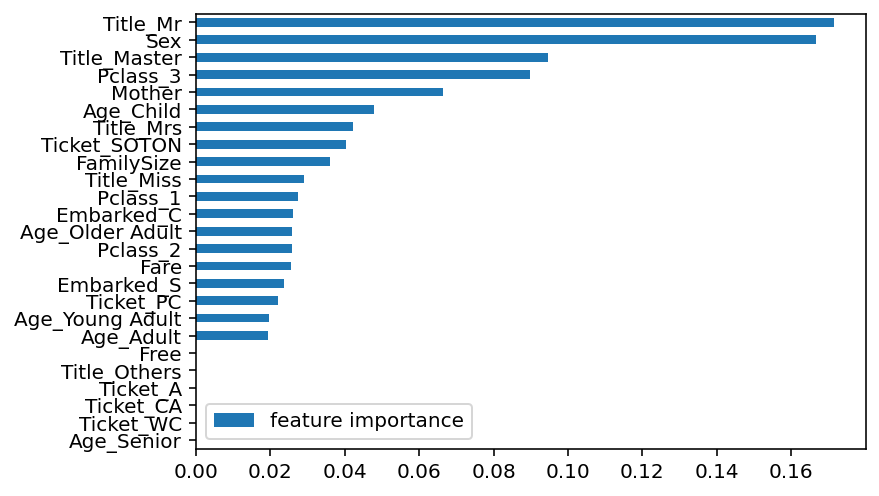

In [965]:
pd.DataFrame(xgb_clf.best_estimator_.feature_importances_, index=X.columns, columns=['feature importance'])\
.sort_values('feature importance').plot(kind='barh');

In [966]:
rf_score = f1_score(y_test, rf_predicted, average='weighted')
xgb_score = f1_score(y_test, xgb_predicted, average='weighted')
predictor = xgb_clf.best_estimator_ if xgb_score > rf_score else rf_clf.best_estimator_

In [967]:
predictdf = df[X.columns].loc[testdf.index]
submission = pd.DataFrame({'PassengerId':predictdf.index,'Survived':predictor.predict(predictdf)})
submission.Survived = submission.Survived.astype(int)
submission.set_index('PassengerId',inplace=True)
submission.to_csv("titanic_submission_result.csv")